In [1]:
from IPython.display import clear_output
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16
clear_output()

In [2]:
import cv2
import numpy as np
import os
import pickle
from pathlib import Path
import glob
# import string
import matplotlib.pyplot as plt
# import random
from tqdm import tqdm 
# from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix, accuracy_score, f1_score
from sklearn import svm
%matplotlib inline

In [3]:
cv2.__version__

'3.4.2'

## 1. Data preprocessing

#### Download dataset

In [4]:
!git clone "https://github.com/Horea94/Fruit-Images-Dataset.git" "/tmp/input"

fatal: destination path '/tmp/input' already exists and is not an empty directory.


#### Split dataset

In [5]:
def getYourFruits(fruits, data_split, print_n=False, k_fold=False):
    images = []
    labels = []
    val = ['Training', 'Test']

    path = Path("/tmp/input/") / data_split
    if print_n: 
      print(f'\nThere are {len(os.listdir(path))} classes in {path}')

    for i, fruit in enumerate(fruits):
        p = path / fruit
        j=0
        for image_path in p.glob("*.jpg"):
            image = cv2.imread(str(image_path), cv2.IMREAD_COLOR)
            image = cv2.resize(image, (dim, dim))
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            images.append(image)
            labels.append(i)
            j+=1
        if(print_n):
            print(f"There are {j} {data_split.upper()} images of {fruits[i].upper()}")
    images = np.array(images)
    labels = np.array(labels)
    return images, labels
    
def getAllFruits():
    fruits = []
    for fruit_path in glob.glob("/tmp/input/Training/*"):
        fruit = fruit_path.split("/")[-1]
        fruits.append(fruit)
    return fruits

#### Visualize dataset

In [6]:
def plot_image_grid(images, text, nb_rows, nb_cols, figsize=(15, 15)):
    assert len(images) == nb_rows*nb_cols, "Number of images should be the same as (nb_rows*nb_cols)"
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)
    
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].axis('off')
            axs[i, j].title.set_text(text[n])
            axs[i, j].imshow(images[n])
            n += 1        

## 2. SIFT-BOVW pipeline

In [7]:
def computeFeatures(extractor, images):
  keypoints = []
  descriptors = []
  des_imgs = []
  for img in tqdm(images):
    kp, des = extractor.detectAndCompute(img, None)

    keypoints.append(kp)
    des_imgs.append(des)
    
    if des is not None:
      for d in des:
        descriptors.append(d)

  return np.array(keypoints), np.array(descriptors), np.array(des_imgs)

## 3. Classification of feature-vectors

In [8]:
def clustering(k, labels, descriptors):
  batch_size = int(len(labels) / 5)
  kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, verbose=0, random_state=0)
  kmeans = kmeans.fit(descriptors)
  return kmeans

In [9]:
def histograms(k, clusters, kps, image_des):
  clusters.verbose = False

  histo_list = []
  delete_index = []

  for iter in tqdm(range(image_des.shape[0])):
      histo = np.zeros(k)
      nkp = np.size(kps[iter])

      if image_des[iter] is not None:
        for d in image_des[iter]:
            idx = clusters.predict([d])
            histo[idx] += 1/nkp 

        histo_list.append(histo)
      else:
        delete_index.append(iter)
    
  return np.array(histo_list), delete_index

## 4. Hyperparameters tuning

In [10]:
def fit(model, X, Y):
  model.fit(X, Y)
  return model

In [11]:
def predict(model, images, clusters, extractor, proba=True):
  preds = []
  y = []

  delete_index = []

  for i in range(len(images)):
      kp, des = extractor.detectAndCompute(images[i], None)

      x = np.zeros(k)
      nkp = np.size(kp)

      if des is not None:
        for d in des:
            idx = clusters.predict([d])
            x[idx] += 1/nkp

        y.append(x)

        if proba:
          res = model.predict_proba([x])
          preds.append(np.argmax(res))
        else:
          res = model.predict([x])
          preds.append(res)
      else:
        delete_index.append(i)

  return preds, y, delete_index

# 5. Results

In [12]:
# Example for multiclass classification on all the training data
dim = 100 #image height, width
fruits = getAllFruits() 

#Get Images and Labels 
X_train_img, y_train =  getYourFruits(fruits, 'Training', print_n=False, k_fold=False)
X_test_img, y_test = getYourFruits(fruits, 'Test', print_n=False, k_fold=False)

In [13]:
print(X_train_img.shape)
print(X_test_img.shape)

(67692, 100, 100, 3)
(22688, 100, 100, 3)


In [14]:
# X_train_img = X_train_img[:1000]
# y_train = y_train[:1000]
# X_test_img = X_test_img[:1000]
# y_test = y_test[:1000]

In [15]:
surf = cv2.xfeatures2d.SURF_create()

In [16]:
keypoints_surf, descriptors_surf, des_imgs_surf = computeFeatures(surf, X_train_img)
print(descriptors_surf.shape)

100%|██████████| 67692/67692 [03:45<00:00, 299.88it/s]


(1878630, 64)


SURF


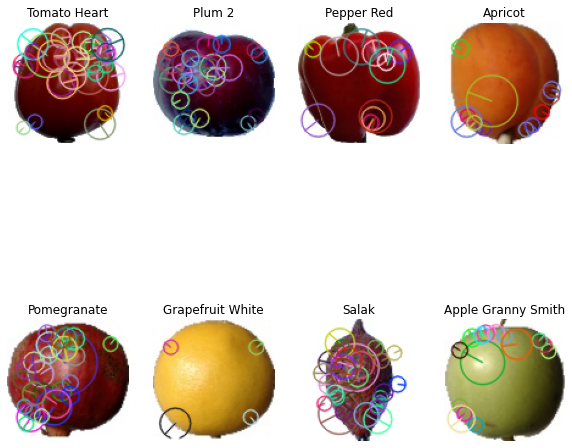

In [17]:
inds = [0, 4002, 5006, 7500, 10000, 15000, 25600, 35000]
ncol, nrows = 2, 4
text = [fruits[y_train[i]] for i in inds]

print('SURF')
drawImg = []

for i in inds:
  drawImg.append(cv2.drawKeypoints(X_train_img[i], keypoints_surf[i], 
                      None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))

plot_image_grid(drawImg, text, ncol, nrows, figsize=(10, 10))

In [18]:
k = len(fruits) * 10

In [19]:
kmeans_surf = clustering(k, fruits, descriptors_surf)

clear_output()

In [20]:
histo_list_surf, delete_index  = histograms(k, kmeans_surf, keypoints_surf, des_imgs_surf)

100%|██████████| 67692/67692 [49:05<00:00, 22.98it/s]


In [21]:
y_train = np.delete(y_train, delete_index)

In [22]:
# clf_sift = svm.LinearSVR(verbose=1)

In [23]:
# clf_surf = fit(clf_surf, histo_list_surf, y_train)

In [24]:
mlp_surf = MLPClassifier(verbose=True, max_iter=600)

In [25]:
mlp_surf = fit(mlp_surf, histo_list_surf, y_train)

Iteration 1, loss = 4.52904519
Iteration 2, loss = 3.30390661
Iteration 3, loss = 2.55384856
Iteration 4, loss = 2.12731212
Iteration 5, loss = 1.85159403
Iteration 6, loss = 1.65779496
Iteration 7, loss = 1.50943279
Iteration 8, loss = 1.39014449
Iteration 9, loss = 1.29109819
Iteration 10, loss = 1.20519223
Iteration 11, loss = 1.13174391
Iteration 12, loss = 1.06632608
Iteration 13, loss = 1.00864961
Iteration 14, loss = 0.95680193
Iteration 15, loss = 0.91007091
Iteration 16, loss = 0.86817934
Iteration 17, loss = 0.82929113
Iteration 18, loss = 0.79468664
Iteration 19, loss = 0.76209629
Iteration 20, loss = 0.73192570
Iteration 21, loss = 0.70465335
Iteration 22, loss = 0.67915780
Iteration 23, loss = 0.65529623
Iteration 24, loss = 0.63332382
Iteration 25, loss = 0.61237789
Iteration 26, loss = 0.59295827
Iteration 27, loss = 0.57486153
Iteration 28, loss = 0.55767811
Iteration 29, loss = 0.54178649
Iteration 30, loss = 0.52598270
Iteration 31, loss = 0.51197264
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [26]:
# save the model to disk
kmeans_surf_filename = 'kmeans_surf.pkl'
mlp_surf_filename = 'mlp_surf.pkl'
# clf_surf_filename = 'clf_surf.pkl'

In [27]:
pickle.dump(kmeans_surf, open(kmeans_surf_filename, 'wb'))
pickle.dump(mlp_surf, open(mlp_surf_filename, 'wb'))
# pickle.dump(clf_surf, open(clf_surf_filename, 'wb'))

In [28]:
# load the model from disk
kmeans_surf = pickle.load(open(kmeans_surf_filename, 'rb'))
mlp_surf = pickle.load(open(mlp_surf_filename, 'rb'))
# clf_surf = pickle.load(open(clf_surf_filename, 'rb'))

In [29]:
y_pred_mlp_surf, y_mlp_surf, delete_index = predict(mlp_surf, X_test_img, kmeans_surf, surf)
# y_pred_clf_surf, y_clf_surf = predict(clf_surf, X_test_img, kmeans_surf, surf)

In [30]:
y_test = np.delete(y_test, delete_index)

In [31]:
# predicted = [ y_pred_mlp_surf, y_pred_clf_surf]
predicted = [y_pred_mlp_surf]
# methods = ["MLP surf", "SVM surf"]
methods = ["MLP surf"]

In [32]:
for i in range(len(predicted)):
  print(f"Accuracy {methods[i]}: {accuracy_score(y_test, predicted[i])}")

Accuracy MLP surf: 0.598210349995592


In [33]:
for i in range(len(predicted)):
  y_pred = predicted[i]
  print(f"F1 score macro {methods[i]}: {f1_score(y_test, y_pred, average='macro')}")
  print(f"F1 score micro {methods[i]}: {f1_score(y_test, y_pred, average='micro')}")
  print(f"F1 score weighted {methods[i]}: {f1_score(y_test, y_pred, average='weighted')}")

F1 score macro MLP surf: 0.5925478163108601
F1 score micro MLP surf: 0.598210349995592
F1 score weighted MLP surf: 0.5940734855683975


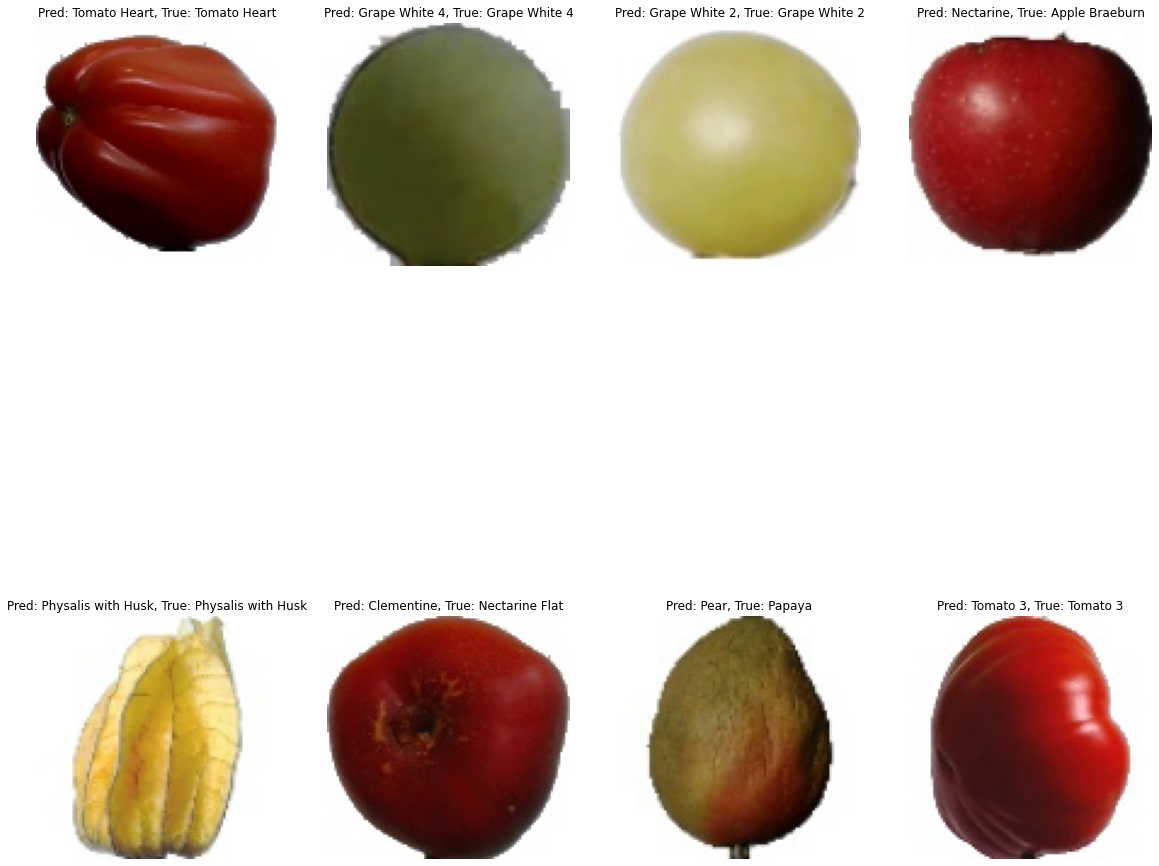

In [34]:
inds = [1, 1050, 6560, 9550, 12000, 15000, 18500, 21000]
nrows = 2
ncol = 4

imgs = []
text = []
for i in inds:
  y_pred = predicted[0]
  text.append(f"Pred: {fruits[y_pred[i]]}, True: {fruits[y_test[i]]}")
  imgs.append(X_test_img[i])

plot_image_grid(imgs, text, nrows, ncol, figsize=(20, 20))

## References

https://www.kaggle.com/waltermaffy/fruit-classification-pca-svm-knn-decision-tree